In [26]:
from utils import *    # contains get_confint(); get_err(); newFontSize(); read_csv_correcting_comments(); getProgress()

import pandas as pd
import numpy as np
import math
import re
import seaborn as sns
from scipy.stats.stats import pearsonr
from scipy.stats import chisquare

import matplotlib
from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from itertools import combinations
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap
from IPython.core.pylabtools import figsize, getfigs
from IPython.display import display, HTML

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
plt.rc('font', size=15) 
display(HTML("<style>.container { width:100% !important; }</style>"))


# E1: Pre-Process Data

In [27]:
# read csv from file
D = pd.read_csv("../data/E1_rawdata/e1_raw.csv")

# Some pre-cleaning - make ID more succinct, rehash  with date of test to disambiguate duplicate names
D['id'] = D['id'].astype(str).str.replace('-','') + "_" + D['date'].astype(str).str.replace('-','')
D['id'] = D['id'].str.replace('2023',"23")
D['id'] = D['id'].str.replace('2024',"24")

# count total number of kids recruited
initial_sample = len(D)

# drop kids who are marked as incomplete
imcomplete_exclusions = len(D[D.apply(lambda x: x['complete'] == 0,axis=1)])
D = D[D.apply(lambda x: x['complete'] != 0,axis=1)]

# drop kids for whom we don't have crucial info: age, condition 1, condition 2
missing_age_exclusions = len(D[D.apply(lambda x: x['ageM'] == "na",axis=1)])
missing_cd1_exclusions = len(D[D.apply(lambda x: x['cd1'] == "na",axis=1)])
missing_cd2_exclusions = len(D[D.apply(lambda x: x['cd2'] == "na",axis=1)])
D = D[D.apply(lambda x: x['ageM'] != "na",axis=1)]
D = D[D.apply(lambda x: x['cd1'] != "na",axis=1)]
D = D[D.apply(lambda x: x['cd2'] != "na",axis=1)]

# drop kids who are marked for exclusion in the spreadsheet column     # FLE03_231005, CHRP04_240130
manual_exclusions = len(D[D.apply(lambda x: x['excl'] == "y",axis=1)])
D = D[D.apply(lambda x: x['excl'] != "y",axis=1)]

# # exclude kids who didn't provide a highest count? Or just keep them in
# D = D.loc[D['hc']!='na']
D['hc'] = D['hc'].replace('na',np.nan).apply(pd.to_numeric, errors='coerce').astype('Int64')

# count number of kids not excluded
final_sample = len(D)

# Add some knower level columns. CP divides ALL subset knowers in one group, from CP knowers in the other
D['CP'] = D.apply(lambda x: True if x['kl'] not in ["0","1","2","3","4"] else False, axis=1)
D['kl_numeric'] = D['kl']
D.loc[D['CP']==True,'kl_numeric'] = np.nan  # convert to int below with other columns

# We had partially annotated some kids' strategies, but should factor those out now. Rename age column here as well
dv_cols = ["s1","s2","s3","s4","s5","s6","s7","s8","s9",'l1','l2','l3','l4','l5','l6','l7','l8','l9',"m1","m2","m3","m4","m5","m6","m7","m8"]
D = process_dataframe(D, dv_cols).rename(columns={'ageM':'age'})

# now we can convert all of those to numeric, and convert other columns to a useful type
D[dv_cols] = D[dv_cols].apply(pd.to_numeric, errors='coerce').astype('Int64')
D = D.astype({'age':'float','kl_numeric':'float','cd1':'float','cd2':'float'}).astype({'kl_numeric':'Int64','cd1':'Int64','cd2':'Int64'})

# Adding a nicer format for displaying age
D["ym"] = D.apply(lambda x: str(int(x['age'] // 12)) + ";" + str(int((x['age'] % 12)) ), axis=1)

# Just keep columns we need
id_cols = ['id','age','ym','hc','kl','CP','kl_numeric','cd1','cd2','exp']
D = D[id_cols + dv_cols]

D = D.loc[~D['id'].isin(['ADI07_230724', 'SBRD07_231127', 'FLA02_231115', 'FLO02_231023'])] # 5 knowers, who didn't do the Large Sets task


# We accidentally over-collected from some groups. Dataframes with and without kids beyond the first 15 in each group
prereg_games = set()

for cp in [False,True]:
    for cd1 in [0,1]:
        for cd2 in [0,1]:
            prereg_games.update(D.loc[(D['CP']==cp)&(D['cd1']==cd1)&(D['cd2']==cd2)].id.unique()[:15])

# # One horizontal for all kids, one horizontal for preregistered kids of Experiment 1
D_incl = D.copy()
D = D.loc[D['id'].isin(prereg_games)]
V = verticalize(D, id_cols, dv_cols)

# Isolate one dataframe for each task and save out to csv
S = V.loc[(V['trialType']=='s')]
L = V.loc[(V['trialType']=='l')]
M = V.loc[(V['trialType']=='m')]

S.loc[S['response']!=0].to_csv('../data/processed_data/small.csv') # exclude blank trials
L.loc[L['response']!=0].to_csv('../data/processed_data/large.csv') # exclude blank trials
M.loc[M['response']!=0].to_csv('../data/processed_data/multi.csv') # exclude blank trials

print("Started with {}, {} were incomplete, {} lacked age, {} cd1, {} cd2, excluded {} manually.".format(
    initial_sample, imcomplete_exclusions, missing_age_exclusions, missing_cd1_exclusions, missing_cd2_exclusions, manual_exclusions))
print("Before excluding 5-knowers, we had {}. Then {}. Some were overcollected, leaving {}.".format(final_sample, len(D_incl), len(D)))

Dnames = D.copy()
Dnames['cd1'] = Dnames['cd1'].apply(lambda x: 'N N' if x else 'N&N')
Dnames['cd2'] = Dnames['cd2'].apply(lambda x: 'two' if x else 'lun')


Dnames.groupby(['CP','cd1'])[['id']].nunique()    # want to balance this for basic analyses
Dnames.groupby(['CP','cd1','cd2'])[['id']].nunique()    # want to balance this for basic analyses

Dnames.groupby(['CP','cd1','cd2'])[['id','age']].agg({'id':'nunique','age':'mean'})

Started with 162, 28 were incomplete, 1 lacked age, 0 cd1, 0 cd2, excluded 1 manually.
Before excluding 5-knowers, we had 132. Then 128. Some were overcollected, leaving 120.


id        age
CP    cd1 cd2               
False N N lun  15  44.244444
          two  15  42.317778
      N&N lun  15  40.794889
          two  15  40.660000
True  N N lun  15  54.635556
          two  15  61.861333
      N&N lun  15  59.194667
          two  15  51.615556

In [28]:
## Simulate Strategies
# 0. Additive
S['normative'] = S['correct']
L['normative'] = L['correct']
# 1. Respond to First Word Only
temp_dict = {"s1":1,"s2":2,"s3":2,"s4":1,"s5":2,"s6":2,"s7":1,"s8":2,"s9":2,
            "l1":10,"l2":10,"l3":10,"l4":10,"l5":10,"l6":10,"l7":10,"l8":10,"l9":10}
S['respToFirst'] = S.apply(lambda x:  str(temp_dict[x['trial']]) == str(x['response']), axis=1)
L['respToFirst'] = L.apply(lambda x:  str(temp_dict[x['trial']]) == str(x['response']), axis=1)
# 2. Respond to Last Word Only
temp_dict = {"s1":1,"s2":2,"s3":1,"s4":1,"s5":2,"s6":1,"s7":1,"s8":2,"s9":1,
             "l1":1,"l2":2,"l3":3,"l4":4,"l5":5,"l6":6,"l7":7,"l8":8,"l9":9}
S['respToLast'] = S.apply(lambda x:  str(temp_dict[x['trial']]) == str(x['response']), axis=1)
L['respToLast'] = L.apply(lambda x:  str(temp_dict[x['trial']]) == str(x['response']), axis=1)
# 3. Interpret as Counting-Style Object-Labelling
S['countingLabels'] = S['response_trunc'] == 2
L['countingLabels'] = L['response_trunc'] == 2
# 4. Animal (Give Big Numbers Always)
S['animal'] = S['response_trunc'] == 0
L['animal'] = L['response_trunc'] == 20

def checkStrategies(df, ignore_large=False):
    # Get some information about how consistent this kid was per task. Maybe best done on for each (repeated) request, within-task ('requestType') but use 'expected' cardinality for now
    response_consistency = df.groupby(['expected'])[['response']].nunique().reset_index().rename({'response':'unique_responses'}, axis=1)['unique_responses'].mean()
    df = df.loc[df['animal']==False] if ignore_large else df
    normative = df['correct'].mean()
    respToFirst = df['respToFirst'].mean()
    respToLast = df['respToLast'].mean()
    countingLabels = df['countingLabels'].mean()
    animal = df['animal'].mean()
    stratlabel_list = ['normative', 'respToFirst','respToLast','countingLabels', 'animal']
    strat_list =      [ normative ,  respToFirst , respToLast , countingLabels ,  animal ]
    maxstrat_ind = np.nanargmax(np.array(strat_list))
    max_strat_pct = np.nanmax(np.array(strat_list))
    max_strat = stratlabel_list[maxstrat_ind] if max_strat_pct > 0 else 'no_max'
    no_max = max_strat_pct == 0
    max_strat_margin = max_strat_pct - max(strat_list[:maxstrat_ind] + strat_list[maxstrat_ind+1 :])
    responsedict = dict(zip(df['sectionTrial'],df['response']))
    output = pd.Series(({**responsedict, **{'response_consistency':response_consistency,
                         'normative':normative,
                         'respToFirst':respToFirst,'respToLast':respToLast,'countingLabels':countingLabels,
                         'animal':animal,'no_max':no_max,
                         'max_strat':max_strat, 'max_strat_pct':max_strat_pct, 'max_strat_margin':max_strat_margin}} ))
    return output
Ks = S.groupby(['id','age','ym','CP','cd1','cd2']).apply(lambda x: checkStrategies(x, ignore_large=False) ).reset_index().set_index('ym')
Kl = L.groupby(['id','age','ym','CP','cd1','cd2']).apply(lambda x: checkStrategies(x, ignore_large=False) ).reset_index().set_index('ym')

# Define the color map for the factor levels
color_map = {
    'normative': 'blue',
    'respToFirst': 'red',
    'respToLast': 'maroon',
    'countingLabels': 'lightblue',
    'animal':'grey',
    'no_max':'k'}
# f , ((a1,a2),(a3,a4)) = plt.subplots(2,2, figsize=(36, 18), sharey=True)
# rot = 270
# temp = Ks.loc[(Ks['cd1']==False)&(Ks['CP']==False)].sort_values(by=['max_strat_pct','max_strat','age'], ascending=False)
# temp['max_strat_pct'].plot.bar(ax=a1, color=temp['max_strat'].map(color_map), xlabel="Age (Y;M)", ylabel="% Strategy", title="Subset Explicit Condition", rot=315)
# temp = Ks.loc[(Ks['cd1']==False)&(Ks['CP']==True)].sort_values(by=['max_strat_pct','max_strat','age'], ascending=False)
# temp['max_strat_pct'].plot.bar(ax=a2, color=temp['max_strat'].map(color_map), xlabel="Age (Y;M)", ylabel="% Strategy", title="CP Explicit Condition", rot=315)
# temp = Ks.loc[(Ks['cd1']==True)&(Ks['CP']==False)].sort_values(by=['max_strat_pct','max_strat','age'], ascending=False)
# temp['max_strat_pct'].plot.bar(ax=a3, color=temp['max_strat'].map(color_map), xlabel="Age (Y;M)", ylabel="% Strategy", title="Subset Implicit Condition", rot=315)
# temp = Ks.loc[(Ks['cd1']==True)&(Ks['CP']==True)].sort_values(by=['max_strat_pct','max_strat','age'], ascending=False)
# temp['max_strat_pct'].plot.bar(ax=a4, color=temp['max_strat'].map(color_map), xlabel="Age (Y;M)", ylabel="% Strategy", title="CP Implicit Condition", rot=315)
# newFontSize([a1,a2,a3,a4],fs=28)
# plt.tight_layout()
# f , ((a1,a2)) = plt.subplots(1,2, figsize=(18, 5), sharey=True)
# rot = 270
# temp = Kl.loc[(Kl['cd1']==False)].sort_values(by=['max_strat_pct','max_strat','age'], ascending=False)
# temp['max_strat_pct'].plot.bar(ax=a1, color=temp['max_strat'].map(color_map), xlabel="Age (Y;M)", ylabel="% Strategy", title="CP Explicit Condition", rot=315)
# temp = Kl.loc[(Kl['cd1']==True)].sort_values(by=['max_strat_pct','max_strat','age'], ascending=False)
# temp['max_strat_pct'].plot.bar(ax=a2, color=temp['max_strat'].map(color_map), xlabel="Age (Y;M)", ylabel="% Strategy", title="CP Implicit Condition", rot=315)
# newFontSize([a1,a2],fs=14)
# plt.tight_layout()


# Ks.loc[Ks['max_strat_pct']>=7/9]['max_strat'].value_counts()
# Kl.loc[Kl['max_strat_pct']>=7/9]['max_strat'].value_counts()

strats = ['normative','countingLabels','respToFirst','respToLast','animal']

SBE = Ks.loc[(Ks['max_strat_pct']>=7/9)&(Ks['CP'].isin([False]))&(Ks['cd1'].isin([0]))][['max_strat']].value_counts()
SBI = Ks.loc[(Ks['max_strat_pct']>=7/9)&(Ks['CP'].isin([False]))&(Ks['cd1'].isin([1]))][['max_strat']].value_counts()
CPE = Ks.loc[(Ks['max_strat_pct']>=7/9)&(Ks['CP'].isin([True]))&(Ks['cd1'].isin([0]))][['max_strat']].value_counts()
CPI = Ks.loc[(Ks['max_strat_pct']>=7/9)&(Ks['CP'].isin([True]))&(Ks['cd1'].isin([1]))][['max_strat']].value_counts()
strat_counts = []
for valcount in [SBE,SBI,CPE,CPI]:
    for strat in strats:
        strat_counts = np.append(strat_counts,valcount[strat]) if strat in valcount else np.append(strat_counts,0)
    strat_counts = np.append(strat_counts,valcount.sum())
for strat in strats:
    total_count = 0
    total_count = total_count + SBE[strat] if strat in SBE else total_count
    total_count = total_count + SBI[strat] if strat in SBI else total_count
    total_count = total_count + CPE[strat] if strat in CPE else total_count
    total_count = total_count + CPI[strat] if strat in CPI else total_count
    strat_counts = np.append(strat_counts,total_count)

strat_counts = np.append(strat_counts, SBE.sum() + SBI.sum() + CPE.sum() + CPI.sum())
strat_counts = strat_counts.astype(int).astype(str)
for i,x in enumerate(strat_counts):
    strat_counts[i] = x if len(x) == 2 else str(x) + " "

print("""Table 1.
                     Additive    Indexing    FirstWord    LastWord    GiveMany     Total
Subset    Explicit   {}          {}          {}           {}          {}           {}
          Implicit   {}          {}          {}           {}          {}           {}
CP        Explicit   {}          {}          {}           {}          {}           {}
          Implicit   {}          {}          {}           {}          {}           {}
-------------------------------------------------------------------------------------------
                     {}          {}          {}           {}          {}           {} / {} total
          """.format(*strat_counts,len(Ks)))




CPE = Kl.loc[(Kl['max_strat_pct']>=7/9)&(Kl['cd1'].isin([0]))][['max_strat']].value_counts()
CPI = Kl.loc[(Kl['max_strat_pct']>=7/9)&(Kl['cd1'].isin([1]))][['max_strat']].value_counts()
strat_counts = []
for valcount in [CPE,CPI]:
    for strat in strats:
        strat_counts = np.append(strat_counts,valcount[strat]) if strat in valcount else np.append(strat_counts,0)
    strat_counts = np.append(strat_counts,valcount.sum())
for strat in strats:
    total_count = 0
    total_count = total_count + CPE[strat] if strat in CPE else total_count
    total_count = total_count + CPI[strat] if strat in CPI else total_count
    strat_counts = np.append(strat_counts,total_count)
strat_counts = np.append(strat_counts, CPE.sum() + CPI.sum())
strat_counts = strat_counts.astype(int).astype(str)
for i,x in enumerate(strat_counts):
    strat_counts[i] = x if len(x) == 2 else str(x) + " "

print("""Table 1.5.
                     Additive    Indexing    FirstWord    LastWord    GiveMany     Total
CP        Explicit   {}          {}          {}           {}          {}           {}
          Implicit   {}          {}          {}           {}          {}           {}
-------------------------------------------------------------------------------------------
                     {}          {}          {}           {}          {}           {} / {} total
          """.format(*strat_counts,len(Kl)))


Table 1.
                     Additive    Indexing    FirstWord    LastWord    GiveMany     Total
Subset    Explicit   5           3           0            0           2            10
          Implicit   0           2           4            3           2            11
CP        Explicit   19          3           0            0           1            23
          Implicit   13          5           3            0           2            23
-------------------------------------------------------------------------------------------
                     37          13          7            3           7            67 / 120 total
          
Table 1.5.
                     Additive    Indexing    FirstWord    LastWord    GiveMany     Total
CP        Explicit   12          0           4            0           1            17
          Implicit   11          1           4            0           5            21
-------------------------------------------------------------------------------------

## E1 Descriptive Stats + Strategy Annotations

In [29]:
print("Total of {} kids, age range {} to {} months, M = {}, SD = {}".format(
    D.age.count(),np.round(D.age.min(),2), np.round(D.age.max(),2), np.round(D.age.mean(),2), np.round(D.age.std(),2)))

print("Knower levels: 0 ({}),  1 ({}),  2 ({}),  3 ({}),  4 ({}),  CP ({})".format(
    D['kl'].isin(['0']).sum(), D['kl'].isin(['1']).sum(), D['kl'].isin(['2']).sum(), D['kl'].isin(['3']).sum(),
    D['kl'].isin(['4']).sum(), D['kl'].isin(['5','6','CP']).sum() ))


Total of 120 kids, age range 24.17 to 83.77 months, M = 49.42, SD = 11.38
Knower levels: 0 (3),  1 (6),  2 (20),  3 (22),  4 (9),  CP (60)


In [30]:
temp = get_confint(S, 'cd1', 'correct')
print("Small Sets task by condition:")
print("Explicit: {} ± {}%".format(np.round(100*temp.loc[0,'mean'],1), np.round(100*temp.loc[0,'yerr'],1) ))
print("Implicit: {} ± {}%".format(np.round(100*temp.loc[1,'mean'],1), np.round(100*temp.loc[1,'yerr'],1) ))
print()

temp = get_confint(S, ['cd1','CP'], 'correct')
print("Small Sets task by CP status and condition:")
print("Explicit Subset: {} ± {}%".format(np.round(100*temp.loc[(0,False),'mean'],1), np.round(100*temp.loc[(0,False),'yerr'],1) ))
print("Implicit Subset: {} ± {}%".format(np.round(100*temp.loc[(1,False),'mean'],1), np.round(100*temp.loc[(1,False),'yerr'],1) ))
print("Explicit CP: {} ± {}%".format(np.round(100*temp.loc[(0,True),'mean'],1), np.round(100*temp.loc[(0,True),'yerr'],1) ))
print("Implicit CP: {} ± {}%".format(np.round(100*temp.loc[(1,True),'mean'],1), np.round(100*temp.loc[(1,True),'yerr'],1) ))
print()

temp = get_confint(L, 'cd1', 'correct')
print("Large Sets task by condition:")
print("Explicit: {} ± {}%".format(np.round(100*temp.loc[0,'mean'],1), np.round(100*temp.loc[0,'yerr'],1) ))
print("Implicit: {} ± {}%".format(np.round(100*temp.loc[1,'mean'],1), np.round(100*temp.loc[1,'yerr'],1) ))
print()

temp = get_confint(M, 'CP', 'correct')
print("Multiplier task by CP statuts:")
print("Subset: {} ± {}%".format(np.round(100*temp.loc[False,'mean'],1), np.round(100*temp.loc[False,'yerr'],1) ))
print("CP: {} ± {}%".format(np.round(100*temp.loc[True,'mean'],1), np.round(100*temp.loc[True,'yerr'],1) ))
print()

temp = get_confint(M, 'cd2', 'correct')
print("Multiplier task by condition:")
print("Nominal: {} ± {}%".format(np.round(100*temp.loc[0,'mean'],1), np.round(100*temp.loc[0,'yerr'],1) ))
print("Numeral: {} ± {}%".format(np.round(100*temp.loc[1,'mean'],1), np.round(100*temp.loc[1,'yerr'],1) ))


Small Sets task by condition:
Explicit: 54.4 ± 4.2%
Implicit: 36.9 ± 4.1%

Small Sets task by CP status and condition:
Explicit Subset: 35.9 ± 5.7%
Implicit Subset: 18.1 ± 4.6%
Explicit CP: 73.0 ± 5.3%
Implicit CP: 55.6 ± 5.9%

Large Sets task by condition:
Explicit: 51.1 ± 6.0%
Implicit: 39.6 ± 5.8%

Multiplier task by CP statuts:
Subset: 32.5 ± 4.2%
CP: 56.7 ± 4.4%

Multiplier task by condition:
Nominal: 39.8 ± 4.4%
Numeral: 49.4 ± 4.5%


In [31]:
# D.sort_values('kl').reset_index()

# E2: Pre-Process Data

In [32]:

C = pd.read_csv("../data/E2_rawdata/consents.csv")
C['ID'] = C['dot'].str.replace('-','') + "_" + C['loc'] + C['id'].astype(str)    # put IDs into same form as trialdata
cond_dict = {x['ID'] : x['cond'] for i,x in C.iterrows()}                        # map each ID to verified condition
age_dict = {x['ID'] : x['age_m'] for i,x in C.iterrows()}                        # map each ID to age of kid in months
expr_dict = {x['ID'] : x['expr'] for i,x in C.iterrows()}                        # map each ID to experimenter initials

csvs = ["20240713_FL1_AND","20240713_FL2_AND","20240713_FL3_AND","20240713_FL4_AND","20240713_FL5_AND","20240713_FL6_CAT","20240713_FL7_CAT",
        "20240716_FL2_CAT","20240716_FL3_CAT",
        "20240717_FL1_CAT","20240717_FL2_CAT","20240717_FL3_AND",
        "20240720_FL1_AND","20240720_FL2_AND","20240720_FL3_AND","20240720_FL4_AND","20240720_FL5_AND",
        "20240723_FL1_AND","20240723_FL2_AND","20240723_FL3_AND",
        "20240724_FL3_AND","20240724_FL4_AND","20240724_FL6_AND","20240724_FL7_AND",
        "20240727_FL1_AND","20240727_FL2_AND","20240727_FL3_AND","20240727_FL4_AND","20240727_FL5_AND",
        "20240730_FL1_CAT","20240730_FL2_CAT","20240730_FL3_AND",
        "20240730_MOC1_CAT","20240730_MOC2_CAT","20240730_MOC3_CAT",
        "20240731_FL2_AND",
        "20240803_FL1_AND","20240803_FL3_AND","20240803_FL4_CAT",
        "20240806_FL1_CAT","20240806_FL2_CAT","20240806_FL4_AND","20240806_FL5_CAT","20240806_FL6_AND",  # had "20240806_FL3_CAT", but no age for that kid
        "20240807_FL1_CAT","20240807_FL2_CAT","20240807_FL3_CAT",
        "20240810_FL1_CAT","20240810_FL2_AND","20240810_FL3_CAT","20240810_FL5_AND","20240810_FL7_AND",
        "20240813_CT7_CAT",
        "20240813_FL1_CAT","20240813_FL2_CAT",
        "20240814_FL1_AND","20240814_FL3_CAT","20240814_FL4_AND",
        "20240817_FL1_AND","20240817_FL2_AND","20240817_FL3_AND","20240817_FL4_AND",
        "20240821_FL1_AND","20240821_FL2_AND","20240821_FL3_AND","20240821_FL4_AND","20240821_FL5_AND","20240821_FL6_AND",
        "20240824_FL2_AND","20240824_FL4_CAT",
        "20240827_FL1_CAT","20240827_FL2_CAT",
        "20240827_KA2_CAT","20240827_KA3_AND","20240827_KA4_CAT",    # "20240827_KA1_CAT_didExp1","20240827_KA5_CAT_didExp1","20240827_KA6_AND_didExp1",
        "20240828_FL3_CAT","20240828_FL5_CAT",
        "20240831_FL3_AND","20240831_FL4_CAT",
        "20240903_FL1_CAT","20240903_FL2_CAT","20240903_FL3_CAT","20240903_FL4_CAT","20240903_FL5_CAT","20240903_FL6_CAT",
        "20240904_FL1_AND","20240904_FL2_AND",
        "20240907_FL1_AND","20240907_FL5_AND","20240907_FL7_AND"
        
       ]

# for the files just as we downloaded them - the number, names, and meanings of columns changed a bit over time
raw_csv = {}

# read them all up
raw_csv[csvs[0].rsplit('_', 1)[0]] = read_csv_correcting_comments("../data/E2_rawdata/{}.csv".format(csvs[0])) # should do a pre-purge of commas
F = read_csv_correcting_comments("../data/E2_rawdata/{}.csv".format(csvs[0]))
F['date'] = int(csvs[0][:8])

for path in csvs[1:]:
    date = int(path[:8])
    raw_csv[path.rsplit('_', 1)[0]] = read_csv_correcting_comments("../data/E2_rawdata/{}.csv".format(path)) # should do a pre-purge of commas
    f = read_csv_correcting_comments("../data/E2_rawdata/{}.csv".format(path)) # should do a pre-purge of commas
    f['date'] = date
    f['PID'] = f['PID'].str.replace('Other','MOC') if f['PID'].str.contains('Other').sum() > 0 else f['PID']    # specific to MOC2 preschool
    f['PID'] = f['PID'].str.replace('NA','FL') if f['PID'].str.contains('NA').sum() > 0 else f['PID']    # specific to a Fleet kid on July-17
    F = F.append(f, ignore_index=True)

# for making "request" a bit shorter
F['request'] = F['request'].apply(lambda x: abbreviateRequest(x))

# then cast relevant columns as integers
intcols = ['starttime','timestamp','duration','target','response','grab','onebyone','count','group1','group2','group3','more','right','logic','words']
boolcols = ['kidaction', 'spontaneousCounting', 'one', 'two', 'three', 'four', 'five', 'six', 'gi', 'zo', 'AND', 'bignumber', 'distracted', 'question', 'parent', 'prompt', 'other', 'flagged']
F[intcols] = F[intcols].apply(pd.to_numeric, errors='coerce').astype('Int64').fillna(0, downcast='infer')
F[boolcols] = F[boolcols].apply(pd.to_numeric, errors='coerce').astype('Int64').fillna(0, downcast='infer')

# add some new columns
F['correct'] = F['target'] == F['response']         # probably should be saving this from the browser interface too
F['ID'] = F['date'].astype(str) + "_" + F['PID']    # a fully unique set of IDs conjoins date with location and kid
F['cond'] = F['ID'].apply(lambda x: cond_dict[x] if x in cond_dict.keys() else "NO_CONSENT")    # verifying conditions from videos or discussion
F['age']  = F['ID'].apply(lambda x: age_dict[x] if x in age_dict.keys() else "NO_AGE")          # do we have their age?
F['expr']  = F['ID'].apply(lambda x: expr_dict[x] if x in expr_dict.keys() else "NO_EXPR")          # do we know who ran this game?

# see which consented kids currently lack associated data, and data files that currently lack consent forms
kids_nodata = set(C['ID'].unique()).difference(set(F['ID'].unique()))
kids_noform = set(F['ID'].unique()).difference(set(C['ID'].unique()))
kids_formdata = set(F['ID'].unique()).intersection(set(C['ID'].unique()))    # the kids with both

# now we just keep the kids for whom we have both consent form and task data
F = F.loc[F['ID'].isin(kids_formdata)]
C = C.loc[C['ID'].isin(kids_formdata)]

Fbackup = F.copy()



# For now, we'll just look at trial submission events (i.e. the official measures)
T = F.loc[(F['eventType'].isin(['trial']))]

# Our more interesting and fun derived columns
T = getStrategy(T)

# how many games are there in total, pre-exclusion?
total_games = int(T[['ID']].nunique())

# we want kids who have data for every trial. Sometimes data was saved before "three-three" submitted because of blue ipad bug
complete_trial_set = {'make_zo','make_gi', 'fast_zo','fast_gi', 'zozo1','zogi1', 'zogi2','zozo2', 'zogi3','zozo3', 'G_gi','G_zo', 'three-two','three-one','three-three'}

# first, what trials *did* each kid get to, according to the ipad data?
print("Any trials missing from games that aren't standard for incomplete games?")
T.groupby(['ID']).apply(lambda x: getProgress(x['ID'].unique()[0], complete_trial_set.intersection(set(x.loc[x['eventType'].isin(['trial'])]['request'].unique())), complete_trial_set ) )

# now get the list of games that don't have a trial submit event for all trials, add a column for it so we can exclude
incomplete_dict = dict(T.groupby(["ID"]).apply(lambda x: bool(len(complete_trial_set.difference(set(x.loc[x['eventType'].isin(['trial'])]['request'].unique())))) ))
T['incomplete'] = T['ID'].apply(lambda x: incomplete_dict[x])

# for some games, the condition is missing and I don't have video to consult. Hopefully we can figure out, need to do some detectivework
unconditioned_dict = dict(T.groupby(["ID"]).apply(lambda x: x['cond'].isin(['na','idk']).max() ) )
T['unconditioned'] = T['ID'].apply(lambda x: unconditioned_dict[x])


Tbackup = T.copy()


# Make the exclusions
T = T.loc[T['incomplete']==False]      # exclude if they didn't finish the game
T = T.loc[T['unconditioned']==False]   # exclude if we don't know which condition we ran

# Exclude from the full dataframe as well
F = F.loc[F['ID'].isin(list(T['ID'].unique()))]

# how many games are there now, post-exclusion?
clean_games = int(T[['ID']].nunique())

# We may have over-collected by 1 kid in each condition...
and_games = T.loc[T['cond']=='AND'].ID.unique()[:30]
cat_games = T.loc[T['cond']=='CAT'].ID.unique()[:30]
all_games = set(and_games).union(set(cat_games))

# ... so we'll skim off any extra games as well :'/
T = T.loc[T['ID'].isin(all_games)]
F = F.loc[F['ID'].isin(all_games)]

# And we'll need to exclude some formally existing trials that are really duplicate entries
# 20240810_FL5 has two trials for zogi2. The second is just to add an experimenter comment
# 20240814_FL3 has two trials for zozo3. The second is just the kid messing around after having provided their answer (wanted to make a circle shape)
T = pd.concat([T.loc[~T['targetWord'].isin(['zogi','zozo'])],
               T.loc[T['targetWord'].isin(['zogi','zozo'])].drop_duplicates(['ID','request'],keep='first')]).sort_index()

T = pd.concat([T.loc[~T['targetWord'].isin(['three-one','three-three'])],
               T.loc[T['targetWord'].isin(['three-one','three-three'])].drop_duplicates(['ID','request'],keep='first')]).sort_index()



# Let's label kids according to their accuracy in (a) Monkey numbers, (b) three-two / three-and-two, and (c) Giraffe numbers
mk_acc_dict = dict(T.groupby(['ID']).apply(lambda df: df.loc[df['targetWord'].isin(['zogi','zozo'])]['correct'].mean()      ))
T['mk_acc'] = T.apply(lambda x: mk_acc_dict[x['ID']], axis=1)

g5_acc_dict = dict(T.groupby(['ID']).apply(lambda df: df.loc[df['targetWord'].isin(['three-two'])]['correct'].mean()      ))
T['g5_acc'] = T.apply(lambda x: g5_acc_dict[x['ID']], axis=1)

gf_acc_dict = dict(T.groupby(['ID']).apply(lambda df: df.loc[df['targetWord'].isin(['three-one','three-three'])]['correct'].mean()      ))
T['gf_acc'] = T.apply(lambda x: gf_acc_dict[x['ID']], axis=1)

gz_acc_dict = dict(T.groupby(['ID']).apply(lambda df: df.loc[df['request'].isin(['G_gi','G_zo'])]['correct'].mean()      ))
T['gz_acc'] = T.apply(lambda x: gz_acc_dict[x['ID']], axis=1)

# sync the event dataframe up with the trial dataframe
F = F.loc[F['ID'].isin(list(T['ID'].unique()))]
C = C.loc[C['ID'].isin(list(T['ID'].unique()))]

print()
print("Raw Games: {}\nAll Games: {}".format(total_games,clean_games))
print()
print("AND: N = {}    M_age: {}".format(T.loc[T['cond']=='AND'].ID.nunique(),str(np.round(C.loc[C['cond']=='AND']['age_m'].mean(),2))))
print("CAT: N = {}    M_age: {}".format(T.loc[T['cond']=='CAT'].ID.nunique(),str(np.round(C.loc[C['cond']=='CAT']['age_m'].mean(),2))))

print()
print("Mean Age\nPre-Exclusions: {} months (SD: {})\nPost-Exclusion: {} months (SD: {})".format(str(np.round(C['age_m'].mean(),2)),
                                                                                                str(np.round(C['age_m'].std(),2)),
                                                                                                str(np.round(C.loc[C['ID'].isin(list(T['ID'].unique()))]['age_m'].mean(),2)),
                                                                                                str(np.round(C.loc[C['ID'].isin(list(T['ID'].unique()))]['age_m'].std(),2))
                                                                                               ))


Any trials missing from games that aren't standard for incomplete games?
20240717_FL2 missing:   {'make_zo', 'zogi2', 'zozo2'}
20240720_FL3 missing:   {'zogi2', 'three-two', 'zogi1', 'zozo3', 'fast_gi', 'zozo1', 'fast_zo', 'three-one', 'zozo2'}
20240730_FL1 missing:   {'zogi2', 'zogi1', 'zozo1', 'make_zo', 'zozo2'}
20240730_FL3 missing:   {'zogi2', 'zogi1', 'zozo3', 'zogi3', 'zozo1', 'zozo2'}
20240817_FL1 missing:   {'zogi2', 'G_zo', 'G_gi', 'three-two', 'zogi1', 'zozo3', 'zogi3', 'three-one', 'zozo2', 'three-three'}
20240827_KA2 missing:   {'three-two', 'G_zo', 'G_gi', 'zozo3', 'zogi3', 'three-one', 'three-three'}
20240827_KA3 missing:   {'make_gi', 'zogi2', 'G_gi', 'G_zo', 'three-two', 'zogi1', 'fast_gi', 'zozo3', 'zogi3', 'zozo1', 'fast_zo', 'three-one', 'make_zo', 'zozo2', 'three-three'}
20240903_FL2 missing:   {'make_gi', 'zogi2', 'G_gi', 'G_zo', 'three-two', 'zogi1', 'fast_gi', 'zozo3', 'zogi3', 'zozo1', 'fast_zo', 'three-one', 'make_zo', 'zozo2', 'three-three'}

Raw Games: 90
Al

In [33]:
# pre-reg predictor: accuracy during training
Tr = T.loc[(T['phase'].isin(['Train'])) & (T['request'].isin(['make_zo','make_gi','fast_zo','fast_gi','G_gi','G_zo']))]
Trdict = dict(Tr.groupby(['ID'])['correct'].mean())
T['training_acc'] = T['ID'].apply(lambda x: Trdict[x])

# pre-reg predictor: additive responses to the corresponding English composition
G = T.loc[(T['request'].isin(['three-two','three-one','three-three']))]
Gdict = dict(G.groupby(['ID','target'])['correct'].max()) # max rather than mean, because sometimes there may be a "trial submit" without any input, not corresponding to an actual event?
T['giraffe_nums'] = T[['ID','target']].apply(lambda x: Gdict[(x['ID'],6)] if (x['ID'],6) in Gdict else np.nan, axis=1)

# isolating the Monkey generalization trials
Z = T.loc[(T['request'].isin(['zozo1', 'zogi1', 'zogi2', 'zozo2', 'zogi3', 'zozo3']))]

# isolating the Monkey and Giraffe generalization trials together
T['language'] = T['request'].apply(lambda x: "EN" if x in ['three-two','three-one','three-three'] else "MK")
MG = T.loc[(T['request'].isin(['zozo1', 'zogi1', 'zogi2', 'zozo2', 'zogi3', 'zozo3','three-two','three-one','three-three']))]

Z.to_csv('../data/processed_data/monkey.csv')
MG.to_csv('../data/processed_data/giraffe.csv')

print("Saved to CSV")

Saved to CSV


## E2 Descriptive Stats + Strategy Annotations

In [34]:

print("Total of {} kids, age range {} to {} months, M = {}, SD = {}".format(
    T.ID.nunique(),np.round(T.age.min(),2),np.round(T.age.max(),2),
    np.round(T.groupby(['ID'])['age'].mean().mean(),2),np.round(T.groupby(['ID'])['age'].mean().std(),2) ))

temp = get_confint(Z, 'cond', 'correct')
print("Monkey numbers by condition:")
print("Explicit: {} ± {}%".format(np.round(100*temp.loc['AND','mean'],1), np.round(100*temp.loc['AND','yerr'],1) ))
print("Implicit: {} ± {}%".format(np.round(100*temp.loc['CAT','mean'],1), np.round(100*temp.loc['CAT','yerr'],1) ))
print()

temp = get_confint(G, 'cond', 'correct')
print("Giraffe numbers by condition:")
print("Explicit: {} ± {}%".format(np.round(100*temp.loc['AND','mean'],1), np.round(100*temp.loc['AND','yerr'],1) ))
print("Implicit: {} ± {}%".format(np.round(100*temp.loc['CAT','mean'],1), np.round(100*temp.loc['CAT','yerr'],1) ))
print()

temp = get_confint(MG, 'cond', 'correct')
print("Monkey and Giraffe numbers by condition:")
print("Explicit: {} ± {}%".format(np.round(100*temp.loc['AND','mean'],1), np.round(100*temp.loc['AND','yerr'],1) ))
print("Implicit: {} ± {}%".format(np.round(100*temp.loc['CAT','mean'],1), np.round(100*temp.loc['CAT','yerr'],1) ))
print()

temp = get_confint(MG, 'language', 'correct')
print("Monkey and Giraffe numbers by language:")
print("Giraffe: {} ± {}%".format(np.round(100*temp.loc['EN','mean'],1), np.round(100*temp.loc['EN','yerr'],1) ))
print("Monkey: {} ± {}%".format(np.round(100*temp.loc['MK','mean'],1), np.round(100*temp.loc['MK','yerr'],1) ))
print()

temp = get_confint(MG, ['cond','language'], 'correct')
print("Monkey and Giraffe numbers by condition and language:")
print("Giraffe Explicit: {} ± {}%".format(np.round(100*temp.loc[('AND','EN'),'mean'],1), np.round(100*temp.loc[('AND','EN'),'yerr'],1) ))
print("Monkey Explicit: {} ± {}%".format(np.round(100*temp.loc[('AND','MK'),'mean'],1), np.round(100*temp.loc[('AND','MK'),'yerr'],1) ))
print("Giraffe Implicit: {} ± {}%".format(np.round(100*temp.loc[('CAT','EN'),'mean'],1), np.round(100*temp.loc[('CAT','EN'),'yerr'],1) ))
print("Monkey Implicit: {} ± {}%".format(np.round(100*temp.loc[('CAT','MK'),'mean'],1), np.round(100*temp.loc[('CAT','MK'),'yerr'],1) ))
print()


Total of 60 kids, age range 32.5 to 70.67 months, M = 57.1, SD = 8.91
Monkey numbers by condition:
Explicit: 52.8 ± 7.3%
Implicit: 33.9 ± 6.9%

Giraffe numbers by condition:
Explicit: 76.9 ± 8.7%
Implicit: 51.1 ± 10.4%

Monkey and Giraffe numbers by condition:
Explicit: 60.9 ± 5.8%
Implicit: 39.6 ± 5.8%

Monkey and Giraffe numbers by language:
Giraffe: 64.1 ± 7.0%
Monkey: 43.3 ± 5.1%

Monkey and Giraffe numbers by condition and language:
Giraffe Explicit: 76.9 ± 8.7%
Monkey Explicit: 52.8 ± 7.3%
Giraffe Implicit: 51.1 ± 10.4%
Monkey Implicit: 33.9 ± 6.9%



In [35]:
t = T[T['targetWord'].isin(['three-one','three-two','three-three'])]
t = T[T['targetWord'].isin(['zogi','zozo'])]


t['age_m'] = t['age'].apply(lambda x: np.round(x,1))

t['additive']           = t.apply(lambda x: x['response'] == {'zogi':4,'zozo':6, 'three-one':4,'three-two':5,'three-three':6}[x['targetWord']], axis=1)
t['respToFirst']        = t.apply(lambda x: x['response'] == {'zogi':3,'zozo':3, 'three-one':3,'three-two':3,'three-three':3}[x['targetWord']], axis=1)
t['respToLast']         = t.apply(lambda x: x['response'] == {'zogi':1,'zozo':3, 'three-one':1,'three-two':2,'three-three':3}[x['targetWord']], axis=1)
t['countingLabels']     = t.apply(lambda x: x['response'] == {'zogi':2,'zozo':2, 'three-one':2,'three-two':2,'three-three':2}[x['targetWord']], axis=1)
t['animal']             = t.apply(lambda x: x['response'] > 7, axis=1)

def checkStrategy(df):
    add_pct = df['additive'].mean()
    fst_pct = df['respToFirst'].mean()
    lst_pct = df['respToLast'].mean()
    cnt_pct = df['countingLabels'].mean()
    aml_pct = df['animal'].mean()
    stratlabel_list = ['additive', 'respToFirst','respToLast','countingLabels', 'animal']
    strat_list =      [ add_pct ,   fst_pct ,     lst_pct ,     cnt_pct ,       aml_pct ]
    maxstrat_ind = np.argmax(strat_list)
    max_strat_pct = max(strat_list)
    max_strat = stratlabel_list[maxstrat_ind] if max_strat_pct > 0 else 'no_max'
    no_max = max_strat_pct == 0
    max_strat_pct = np.round(max_strat_pct,2)  # if we're just using this for display purposes
    return pd.Series({'max_strat':max_strat,'max_strat_pct':max_strat_pct})
Kt = t.groupby(['cond','ID','age_m']).apply(lambda x: checkStrategy(x)).reset_index().set_index('age_m')

# color_map = {
#     'additive': 'blue',
#     'respToFirst': 'red',
#     'respToLast': 'maroon',
#     'countingLabels': 'lightblue',
#     'animal':'grey',
#     'no_max':'k'}
# f , (a1,a2) = plt.subplots(1,2, figsize=(24, 6), sharey=True)
# rot = 290
# temp = Kt.loc[(Kt['cond']=='CAT')].sort_values(by=['max_strat_pct','max_strat','age_m'], ascending=False)
# temp['max_strat_pct'].plot.bar(ax=a1, color=temp['max_strat'].map(color_map), xlabel="Age (M)", ylabel="% Strategy", title="CAT Condition", rot=rot)
# temp = Kt.loc[(Kt['cond']=='AND')].sort_values(by=['max_strat_pct','max_strat','age_m'], ascending=False)
# temp['max_strat_pct'].plot.bar(ax=a2, color=temp['max_strat'].map(color_map), xlabel="Age (M)", ylabel="% Strategy", title="AND Condition", rot=rot)
# newFontSize([a1,a2],fs=28)
# plt.tight_layout()

strats = ['additive','countingLabels','respToFirst','respToLast','animal']
CPE = Kt.loc[(Kt['max_strat_pct']>=4/6)&(Kt['cond'].isin(['AND']))][['max_strat']].value_counts()
CPI = Kt.loc[(Kt['max_strat_pct']>=4/6)&(Kt['cond'].isin(['CAT']))][['max_strat']].value_counts()
strat_counts = []
for valcount in [CPE,CPI]:
    for strat in strats:
        strat_counts = np.append(strat_counts,valcount[strat]) if strat in valcount else np.append(strat_counts,0)
    strat_counts = np.append(strat_counts,valcount.sum())
for strat in strats:
    total_count = 0
    total_count = total_count + CPE[strat] if strat in CPE else total_count
    total_count = total_count + CPI[strat] if strat in CPI else total_count
    strat_counts = np.append(strat_counts,total_count)
strat_counts = np.append(strat_counts, CPE.sum() + CPI.sum())
strat_counts = strat_counts.astype(int).astype(str)
for i,x in enumerate(strat_counts):
    strat_counts[i] = x if len(x) == 2 else str(x) + " "

print("""Table 2.
                     Additive    Indexing    FirstWord    LastWord    GiveMany     Total
CP        Explicit   {}          {}          {}           {}          {}           {}
          Implicit   {}          {}          {}           {}          {}           {}
-------------------------------------------------------------------------------------------
                     {}          {}          {}           {}          {}           {} / {} total
          """.format(*strat_counts,len(Kt)))



Table 2.
                     Additive    Indexing    FirstWord    LastWord    GiveMany     Total
CP        Explicit   14          1           3            1           0            19
          Implicit   5           1           3            1           1            11
-------------------------------------------------------------------------------------------
                     19          2           6            2           1            30 / 58 total
          


# Figures

Done


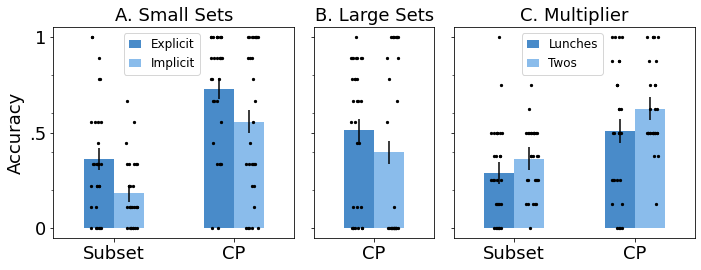

In [36]:
# Now let's look at how subset- and CP-knowers did in each condition, in each task
f , (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4),sharey=True,gridspec_kw={'width_ratios': [4,2,4]})

plot_Ps = True
s = 20
m = '.'
dc = "k"
colour0 = "#498bc9"
colour1 = "#8abceb"
NK_label = 'Subset'
CP_label = 'CP'

params = {'legend.fontsize': 12,
          'legend.handlelength': 1,
          'legend.markerscale': .5}
plt.rcParams.update(params)


# AX1: all the small set trials
S1 = get_err(S.loc[S['cd1']==False], by='CP', dv='correct').rename(columns={'correct':"Explicit",'yerr':"N&Nerr"})
S2 = get_err(S.loc[S['cd1']==True], by='CP', dv='correct').rename(columns={'correct':"Implicit",'yerr':"NNerr"})
s1,err1 = S1[["Explicit"]],S1["N&Nerr"]
s2,err2 = S2[["Implicit"]],S2["NNerr"]

s1.join(s2).plot.bar(ax=ax1,color={"Explicit": colour0, "Implicit": colour1},yerr=[err1,err2])

ax1.set_xticklabels([NK_label,CP_label],rotation=0)
ax1.set_xlabel("")
ax1.set_yticks([0,.5,1])
ax1.set_yticklabels(["0",".5","1"])
ax1.set_title("A. Small Sets")
ax1.legend(loc='upper center', bbox_to_anchor=(0.45, 1))


if plot_Ps == True:
    # now scatter the individual participant means
    # &-condition, subset-knowers, small sets
    temp = S.loc[(S['cd1']==False)&(S['CP']==False)].groupby(['id'])[['correct']].mean()
    ax1.scatter(-.15 + np.random.random(len(temp))* .1 - .05,
                    temp['correct'],
                    zorder=20,s=s,marker=m,c=dc)
    # +-condition, subset-knowers, small sets
    temp = S.loc[(S['cd1']==True)&(S['CP']==False)].groupby(['id'])[['correct']].mean()
    ax1.scatter(.15 + np.random.random(len(temp))* .1 - .05,
                    temp['correct'],
                    zorder=20,s=s,marker=m,c=dc)
    # &-condition, CP-knowers, small sets
    temp = S.loc[(S['cd1']==False)&(S['CP']==True)].groupby(['id'])[['correct']].mean()
    ax1.scatter(.85 + np.random.random(len(temp))* .1 - .05,
                    temp['correct'],
                    zorder=20,s=s,marker=m,c=dc)
    # +-condition, CP-knowers, small sets
    temp = S.loc[(S['cd1']==True)&(S['CP']==True)].groupby(['id'])[['correct']].mean()
    ax1.scatter(1.15 + np.random.random(len(temp))* .1 - .05,
                    temp['correct'],
                    zorder=20,s=s,marker=m,c=dc)

    
# AX2: we know that all of the large set trials are CP knowers anyway
L1 = get_err(L.loc[L['cd1']==False], by='CP', dv='correct').rename(columns={'correct':"N & N",'yerr':"N&Nerr"})
L2 = get_err(L.loc[L['cd1']==True], by='CP', dv='correct').rename(columns={'correct':"N N",'yerr':"NNerr"})
l1,err1 = L1[["N & N"]],L1["N&Nerr"]
l2,err2 = L2[["N N"]],L2["NNerr"]
l1.join(l2).plot.bar(ax=ax2,color={"N & N": colour0, "N N": colour1},yerr=[err1,err2])
ax2.set_xticklabels([CP_label],rotation=0)
ax2.set_xlabel("")
ax2.set_title("B. Large Sets")

if plot_Ps == True:
    # now scatter the individual participant means
    # &-condition, CP-knowers, large sets
    temp = L.loc[L['cd1']==False].groupby(['id'])[['correct']].mean()
    ax2.scatter(-.15 + np.random.random(len(temp))* .1 - .05,
                    temp['correct'],
                    zorder=20,s=s,marker=m,c=dc)
    # +-condition, CP-knowers, large sets
    temp = L.loc[L['cd1']==True].groupby(['id'])[['correct']].mean()
    ax2.scatter(.15 + np.random.random(len(temp))* .1 - .05,
                    temp['correct'],
                    zorder=20,s=s,marker=m,c=dc)


# AX3: now all the multiplier trials
trials_of_interest = ['m2','m4']
M1 = get_err(M.loc[(M['cd2']==False)&(M['trialType']=='m')], by='CP', dv='correct').rename(columns={'correct':"Lunches",'yerr':"Luncheserr"})
M2 = get_err(M.loc[(M['cd2']==True)&(M['trialType']=='m')], by='CP', dv='correct').rename(columns={'correct':"Twos",'yerr':"Twoserr"})
m1,err1 = M1[["Lunches"]],M1["Luncheserr"]
m2,err2 = M2[["Twos"]],M2["Twoserr"]

m1.join(m2).plot.bar(ax=ax3,color={"Lunches": colour0, "Twos": colour1},yerr=[err1,err2])
ax3.set_xticklabels([NK_label,CP_label],rotation=0)
ax3.set_xlabel("")
ax3.set_title("C. Multiplier")
ax3.legend(loc='upper center', bbox_to_anchor=(0.45, 1))

if plot_Ps == True:
    # for each experimental group, we'll plot individ"ual performance
    groups = [{'cd2':False,'cp':False,'type':'m','trials':trials_of_interest,'x_loc':-.15},
              {'cd2':True,'cp':False,'type':'m','trials':trials_of_interest,'x_loc':.15},
              {'cd2':False,'cp':True,'type':'m','trials':trials_of_interest,'x_loc':.85},
              {'cd2':True,'cp':True,'type':'m','trials':trials_of_interest,'x_loc':1.15}]
    for g in groups:
        temp = M.loc[(M['cd2']==g['cd2'])&(M['CP']==g['cp'])&(M['trialType']==g['type'])].groupby(['id'])[['correct']].mean()
    #     temp = D.loc[(D['cd2']==g['cd2'])&(D['CP']==g['cp'])&(D['trial'].isin(g['trials']))].groupby(['id'])[['correct']].mean()
        ax3.scatter(g['x_loc'] + np.random.random(len(temp))* .1 - .05,
                    temp['correct'],
                    zorder=20,s=s,marker=m,c=dc)


# FIG: setting appearance parameters for everything
ax1.set_ylim(-.05,1.05)
ax1.set_ylabel("Accuracy")
ax1.set_yticks([0,.5,1])

# ax1.get_legend().remove()
ax2.get_legend().remove()
# ax3.get_legend().remove()

newFontSize([ax1,ax2,ax3],fs=18)

plt.tight_layout()

f.savefig('../figures/figure2.pdf', bbox_inches="tight")
f.savefig('../figures/figure2.png', bbox_inches="tight")

print("Done")

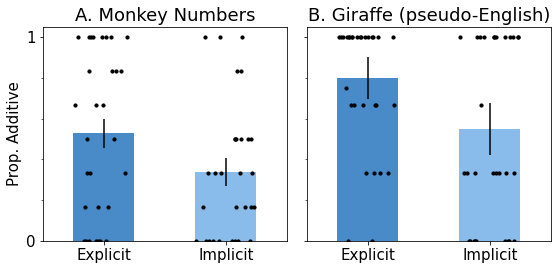

In [37]:

f , (a1,a2) = plt.subplots(1,2,figsize=(8,4), sharey=True)

mg_MK = get_confint(MG.loc[MG['language'].isin(["MK"]) & MG['target'].isin([4,6])],'cond','correct')
mg_EN = get_confint(MG.loc[MG['language'].isin(["EN"]) & MG['target'].isin([4,6])],'cond','correct')

mg_MK['mean'].plot.bar(ax=a1, yerr=[mg_MK['yerr']], color=["#498bc9","#8abceb"], rot=0, title="A. Monkey Numbers")
mg_EN['mean'].plot.bar(ax=a2, yerr=[mg_EN['yerr']], color=["#498bc9","#8abceb"], rot=0, title="B. Giraffe (pseudo-English)")

temp1 = MG.loc[MG['cond'].isin(["AND"]) & MG['language'].isin(["MK"])].groupby(['ID'])['correct'].mean()
temp2 = MG.loc[MG['cond'].isin(["CAT"]) & MG['language'].isin(["MK"])].groupby(['ID'])['correct'].mean()
temp3 = MG.loc[MG['cond'].isin(["AND"]) & MG['language'].isin(["EN"])].groupby(['ID'])['correct'].mean()
temp4 = MG.loc[MG['cond'].isin(["CAT"]) & MG['language'].isin(["EN"])].groupby(['ID'])['correct'].mean()

a1.scatter(x=np.random.random(len(temp1))* .5 - .25, y=temp1, c='k', s=10, zorder=200)
a1.scatter(x=np.random.random(len(temp2))* .5 + .75, y=temp2, c='k', s=10, zorder=200)
a2.scatter(x=np.random.random(len(temp3))* .5 - .25, y=temp3, c='k', s=10, zorder=200)
a2.scatter(x=np.random.random(len(temp4))* .5 + .75, y=temp4, c='k', s=10, zorder=200)

a1.set_xticklabels(["Explicit","Implicit"])
a2.set_xticklabels(["Explicit","Implicit"])

a1.set_xlabel("")
a2.set_xlabel("")

a1.set_yticks([0,1])
a1.set_ylabel("Prop. Additive")
plt.tight_layout()

f.savefig('../figures/figure3.pdf', bbox_inches="tight")
f.savefig('../figures/figure3.png', bbox_inches="tight")
